In [1]:
import os
import json
import gc
from glob import glob
from tqdm.auto import tqdm
from typing import List, Tuple, Optional, Any, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import albumentations as A
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2

from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from evaluate import load

import segmentation_models_pytorch as smp
from torchmetrics.functional import dice
import wandb

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from operator import itemgetter
from PIL import Image

from collections import namedtuple

In [2]:
image_paths = sorted(list(glob('./data/leftImg8bit_trainvaltest/leftImg8bit/train/*/*.png')))
image_paths[:5]

['./data/leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png',
 './data/leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000001_000019_leftImg8bit.png',
 './data/leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000002_000019_leftImg8bit.png',
 './data/leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000003_000019_leftImg8bit.png',
 './data/leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000004_000019_leftImg8bit.png']

In [3]:
label_paths = sorted(list(glob('./data/gtFine_trainvaltest/gtFine/train/*/*_gtFine_labelIds.png')))
label_paths[:5]

['./data/gtFine_trainvaltest/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png',
 './data/gtFine_trainvaltest/gtFine/train/aachen/aachen_000001_000019_gtFine_labelIds.png',
 './data/gtFine_trainvaltest/gtFine/train/aachen/aachen_000002_000019_gtFine_labelIds.png',
 './data/gtFine_trainvaltest/gtFine/train/aachen/aachen_000003_000019_gtFine_labelIds.png',
 './data/gtFine_trainvaltest/gtFine/train/aachen/aachen_000004_000019_gtFine_labelIds.png']

# Datasets

In [4]:
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [5]:
class CityScapesDataset(data.Dataset):
    def __init__(self, image_paths: List[str], mask_paths: List[str], stage: str = "train", image_size: int = 1024) -> None:
        super(CityScapesDataset, self).__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size

        if stage == "train":
            self.transforms = A.Compose([
                A.augmentations.Resize(height=self.image_size, width=self.image_size, interpolation=0),
#                 A.augmentations.Rotate(limit=90, p=0.5),
                A.HorizontalFlip(0.5),
#                 A.augmentations.transforms.ColorJitter(p=0.5),
                A.Normalize(),
                A.pytorch.ToTensorV2(),
            ])
#             self.transforms = A.Compose([
#                 A.Resize(height=self.image_size, width=self.image_size, interpolation=0),
#                 A.Normalize( ),
# #                 A.ToFloat(),
#                 ToTensorV2(),
#             ])


        else:
            self.transforms = A.Compose([
                A.Resize(height=self.image_size, width=self.image_size, interpolation=0),
                A.Normalize(),
                ToTensorV2()
            ])

        self.target_train_ids = []
        self.target_ids = []
        self.target_colors = []
        self.target_labels = []

        for label in labels:
            if label.trainId != 255 and label.trainId != -1:
                self.target_colors.append(label.color)
                self.target_labels.append(label.name)
                self.target_train_ids.append(label.trainId)
                self.target_ids.append(label.id)

        self.cmap = dict(zip(self.target_train_ids, self.target_colors))
        self.idmap = dict(zip(self.target_ids, self.target_train_ids))


    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        image = np.array(Image.open(self.image_paths[idx]))
        mask = np.array(Image.open(self.mask_paths[idx]))

        transformed = self.transforms(image=image, mask=mask)

        image, mask = transformed['image'], transformed['mask']

        unique = pd.Series(mask.reshape(-1)).unique()

        for ele in unique:
            if ele not in self.idmap.keys():
                mask = mask.where(mask != ele, 255)

        unique = pd.Series(mask.reshape(-1)).unique()
        # print(unoq)
        for k, v in self.idmap.items():
            mask = mask.where(mask != k, v)

        new_mask = torch.stack([mask]*3, axis=-1)
        new_mask.shape

        for k, v in self.cmap.items():
            # print(k, v)
            new_mask = new_mask.where(new_mask != k, torch.LongTensor(v))

        return {
            'image': image.clone(),
            'mask': mask,
            'colored': new_mask,
            'instance': np.array(Image.open(self.mask_paths[idx]))
        }

# Model

In [6]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b5-finetuned-cityscapes-1024-1024",
            ignore_mismatched_sizes=True,
        )

    def forward(self, batch: Dict[str, torch.Tensor]) -> torch.Tensor:
        outputs = self.model(pixel_values=batch['image'])

        upsampled_logits = F.interpolate(
            outputs.logits,
            size=batch['mask'].shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        return upsampled_logits

## Inference

In [7]:
mean_iou = load("mean_iou")
model = SegmentationModel()
dataset = CityScapesDataset(image_paths, label_paths, image_size=1024, stage="train")
loader = data.DataLoader(dataset, batch_size=1, shuffle=True)

In [8]:
batch = next(iter(loader))
batch.keys()

dict_keys(['image', 'mask', 'colored', 'instance'])

In [9]:
batch['image'].shape

torch.Size([1, 3, 1024, 1024])

In [10]:
y = model(batch)
y.shape

torch.Size([1, 19, 1024, 1024])

In [11]:
pred = torch.argmax(y, 1)
pred.shape

torch.Size([1, 1024, 1024])

In [12]:
from pprint import pprint

In [13]:
set(pd.Series(batch['mask'].reshape(-1)).unique())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 255}

  0%|          | 0/2975 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


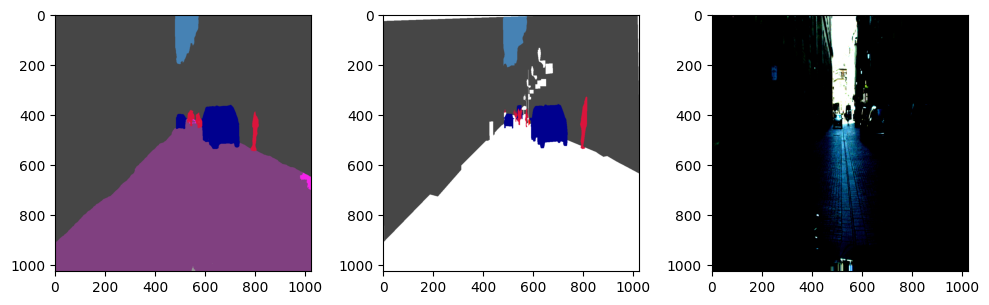

/Users/aneeshaparajit/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/aneeshaparajit/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'mean_accuracy': 0.5897138231257012,
 'mean_iou': 0.4930121145475059,
 'overall_accuracy': 0.9912079504203896,
 'per_category_accuracy': array([       nan,        nan, 0.99896944,        nan,        nan,
       0.        ,        nan,        nan,        nan,        nan,
       0.90059712, 0.68031189, 0.        , 0.95840448,        nan,
              nan,        nan,        nan,        nan]),
 'per_category_iou': array([0.        ,        nan, 0.9911199 ,        nan,        nan,
       0.        ,        nan,        nan,        nan,        nan,
       0.8952514 , 0.61541174, 0.        , 0.94930176,        nan,
              nan,        nan,        nan,        nan])}
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


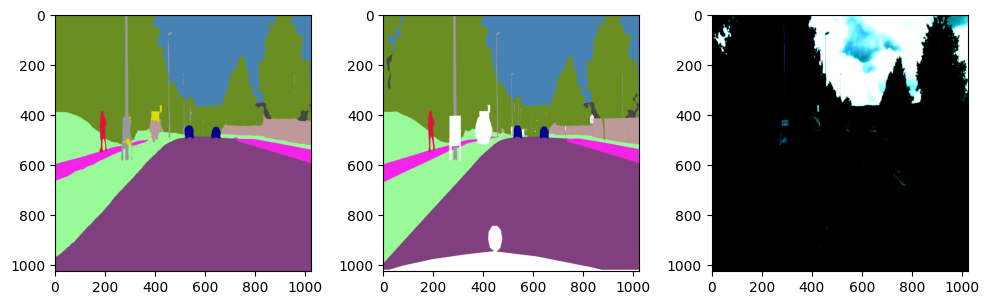

{'mean_accuracy': 0.8949227640042736,
 'mean_iou': 0.7725288278677518,
 'overall_accuracy': 0.9801266942414962,
 'per_category_accuracy': array([0.99859656, 0.92702538, 0.5       ,        nan, 0.93533835,
       0.75989148,        nan,        nan, 0.99205621, 0.96544183,
       0.96540774, 0.942546  ,        nan, 0.9629241 ,        nan,
              nan,        nan,        nan,        nan]),
 'per_category_iou': array([0.99352395, 0.91009847, 0.43819318,        nan, 0.87276629,
       0.67395228,        nan, 0.        , 0.95889173, 0.94880211,
       0.95839581, 0.83610926,        nan, 0.90708402,        nan,
              nan,        nan,        nan,        nan])}
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


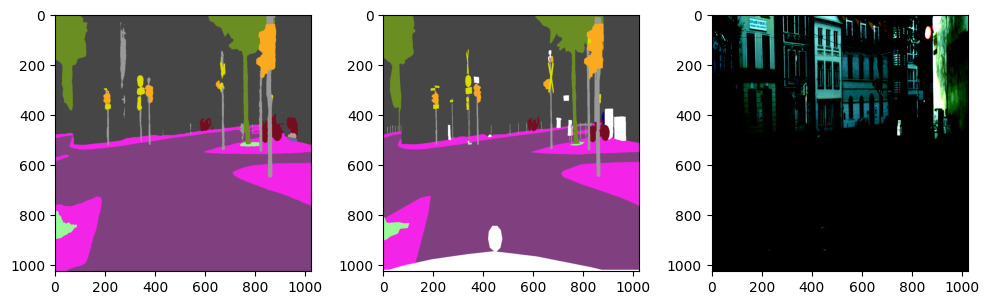

{'mean_accuracy': 0.7939934613777053,
 'mean_iou': 0.638234208238441,
 'overall_accuracy': 0.964880177932281,
 'per_category_accuracy': array([0.98442225, 0.93528273, 0.97169782,        nan,        nan,
       0.7712193 , 0.93573528, 0.64438202, 0.95629234, 0.82027376,
              nan,        nan,        nan, 0.        ,        nan,
              nan,        nan,        nan, 0.92062911]),
 'per_category_iou': array([0.97801761, 0.87682183, 0.94921589, 0.        ,        nan,
       0.54285606, 0.85774268, 0.53003697, 0.90390914, 0.62452802,
              nan,        nan,        nan, 0.        ,        nan,
              nan,        nan,        nan, 0.75744809])}
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


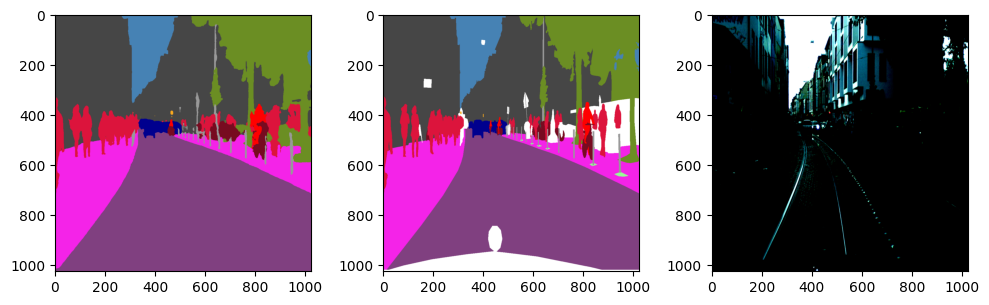

{'mean_accuracy': 0.7555914001597186,
 'mean_iou': 0.6184190771840281,
 'overall_accuracy': 0.9670532720205492,
 'per_category_accuracy': array([0.99489478, 0.96255645, 0.9606155 ,        nan,        nan,
       0.77015187, 0.02061856,        nan, 0.98776158, 0.        ,
       0.95440996, 0.87690499, 0.78414877, 0.93786747,        nan,
              nan,        nan,        nan, 0.81716687]),
 'per_category_iou': array([0.99140069, 0.94252342, 0.94679223,        nan,        nan,
       0.54142285, 0.00740741, 0.        , 0.91045984, 0.        ,
       0.9500414 , 0.77858965, 0.5532646 , 0.79327957,        nan,
              nan,        nan,        nan, 0.62426632])}
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


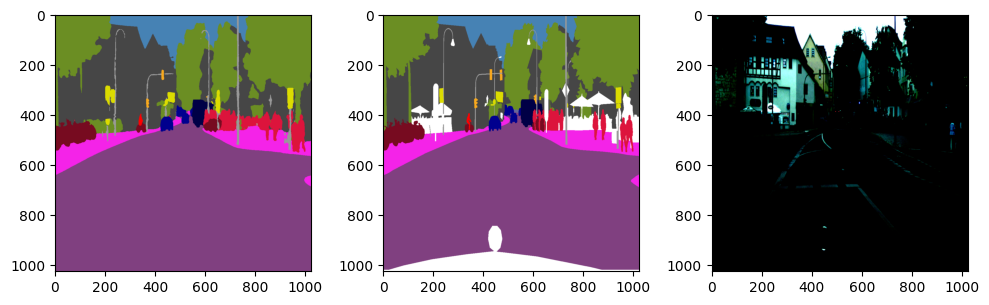

{'mean_accuracy': 0.8142917869851752,
 'mean_iou': 0.7487602598707317,
 'overall_accuracy': 0.9738853148381903,
 'per_category_accuracy': array([0.99755106, 0.95031562, 0.94777715, 0.        ,        nan,
       0.82190531, 0.4834523 , 0.87931818, 0.97553762,        nan,
       0.95914763, 0.89875551, 0.75090253, 0.91744233, 0.85617652,
              nan,        nan,        nan, 0.96180326]),
 'per_category_iou': array([0.99649172, 0.93122094, 0.91132905, 0.        ,        nan,
       0.61991223, 0.46914358, 0.75967014, 0.93242348,        nan,
       0.95068638, 0.79960787, 0.61086637, 0.82391423, 0.82418605,
              nan,        nan,        nan, 0.85319161])}
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


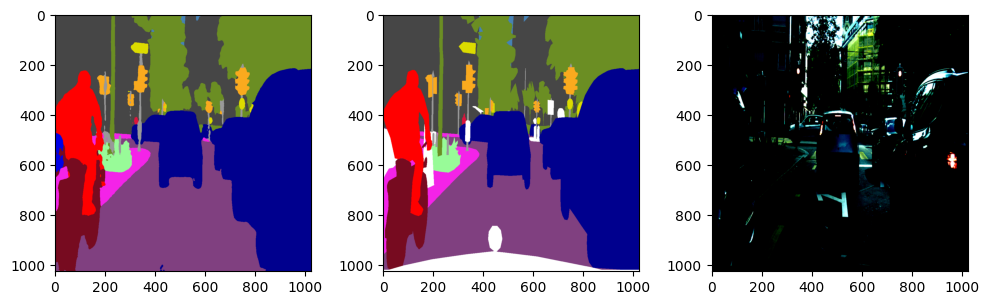

{'mean_accuracy': 0.86112101859699,
 'mean_iou': 0.7470697764721248,
 'overall_accuracy': 0.9638096234760367,
 'per_category_accuracy': array([0.95163929, 0.79596203, 0.95318334,        nan,        nan,
       0.64652391, 0.87669587, 0.85271822, 0.97813287, 0.94183337,
       0.51628151, 0.73006135, 0.9905616 , 0.99855584,        nan,
              nan,        nan,        nan, 0.96242404]),
 'per_category_iou': array([0.9491462 , 0.74990552, 0.92537976,        nan,        nan,
       0.45429249, 0.80003869, 0.79391006, 0.9405146 , 0.87425635,
       0.51331593, 0.68260038, 0.92140398, 0.97041075,        nan,
              nan,        nan, 0.        , 0.88380215])}
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


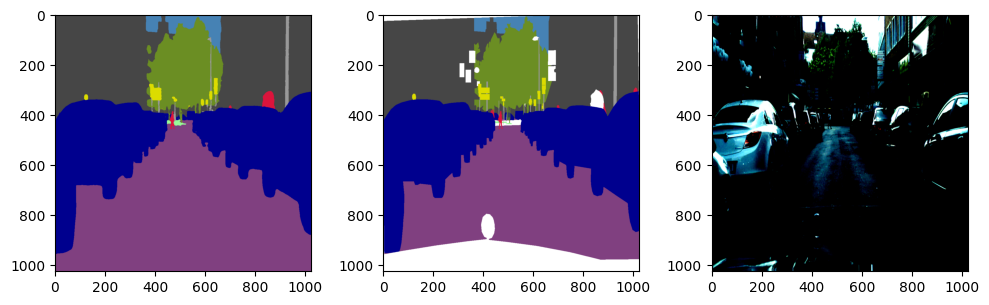

{'mean_accuracy': 0.8927138736205096,
 'mean_iou': 0.7419808615236232,
 'overall_accuracy': 0.9817589498910109,
 'per_category_accuracy': array([0.97783501,        nan, 0.98906259,        nan,        nan,
       0.81484666,        nan, 0.89950779, 0.96821402, 0.97674419,
       0.92929479, 0.48425197,        nan, 0.99466785,        nan,
              nan,        nan,        nan,        nan]),
 'per_category_iou': array([0.97720748,        nan, 0.97269973,        nan,        nan,
       0.67505639, 0.        , 0.81584821, 0.9312235 , 0.73316708,
       0.9118887 , 0.43259086,        nan, 0.97012665,        nan,
              nan,        nan,        nan,        nan])}
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


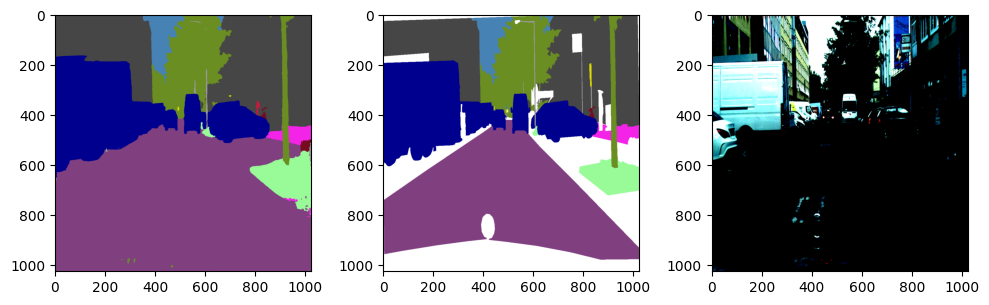

{'mean_accuracy': 0.7744668178531897,
 'mean_iou': 0.6817008019359838,
 'overall_accuracy': 0.9839037927844588,
 'per_category_accuracy': array([0.99902888, 0.8782027 , 0.99159343,        nan,        nan,
       0.30305755,        nan, 0.03553922, 0.96188548, 0.98879346,
       0.90958679,        nan,        nan, 0.99070615,        nan,
              nan,        nan,        nan, 0.68627451]),
 'per_category_iou': array([0.99794574, 0.87280482, 0.96054236,        nan,        nan,
       0.2648677 ,        nan, 0.03108253, 0.91813478, 0.97135281,
       0.90378435, 0.        ,        nan, 0.98679589,        nan,
              nan,        nan,        nan, 0.59139785])}
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


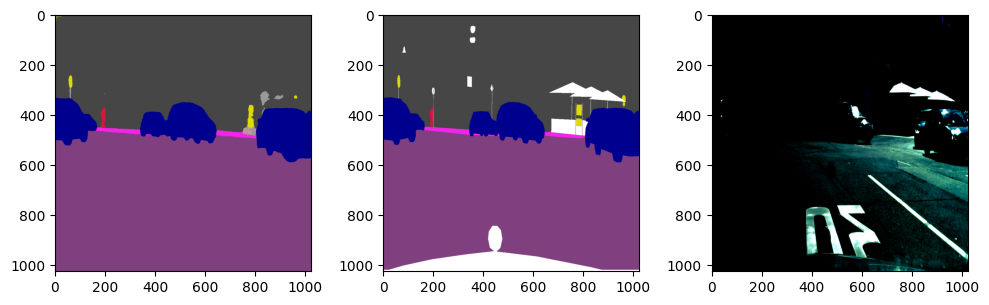

{'mean_accuracy': 0.8311714644690041,
 'mean_iou': 0.5834122902544583,
 'overall_accuracy': 0.991416057794505,
 'per_category_accuracy': array([0.99433983, 0.83559028, 0.99454148,        nan,        nan,
       0.19298246,        nan, 0.82447665,        nan,        nan,
              nan, 0.9842233 ,        nan, 0.99204626,        nan,
              nan,        nan,        nan,        nan]),
 'per_category_iou': array([0.99358068, 0.78336589, 0.98800245,        nan, 0.        ,
       0.1426102 ,        nan, 0.71309192, 0.        ,        nan,
              nan, 0.67358804,        nan, 0.95647143,        nan,
              nan,        nan,        nan,        nan])}
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


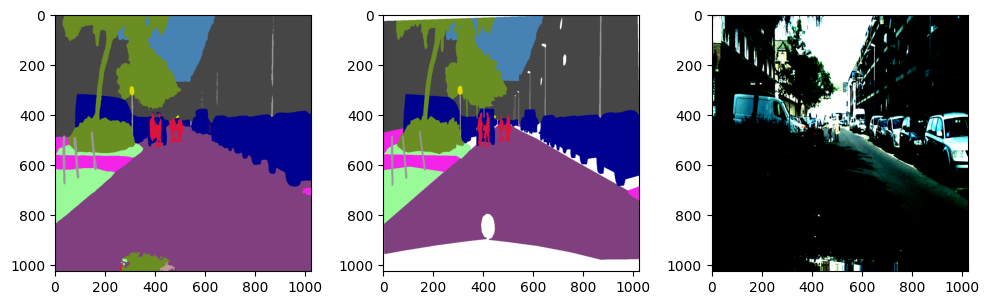

{'mean_accuracy': 0.8908717429721575,
 'mean_iou': 0.7526402685509619,
 'overall_accuracy': 0.969685768700876,
 'per_category_accuracy': array([0.99587141, 0.77683768, 0.98014148,        nan,        nan,
       0.68371837,        nan, 0.79210926, 0.96214413, 0.95015292,
       0.93467499, 0.87179844,        nan, 0.96126875,        nan,
              nan,        nan,        nan,        nan]),
 'per_category_iou': array([0.99219672, 0.74495826, 0.94816909,        nan,        nan,
       0.5618333 ,        nan, 0.66075949, 0.88549513, 0.90511542,
       0.91906707, 0.71914112,        nan, 0.94230736,        nan,
              nan,        nan,        nan, 0.        ])}
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


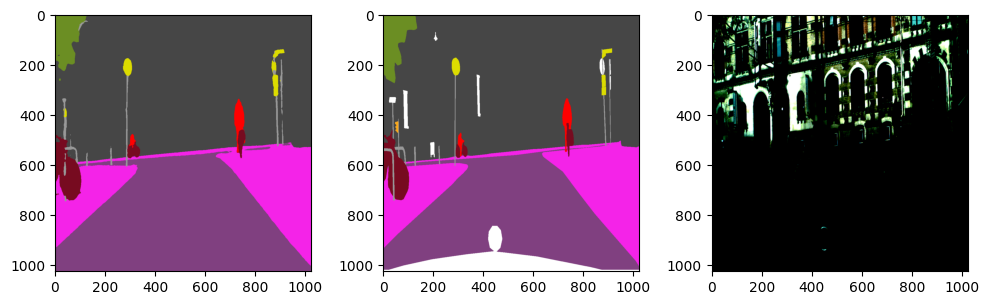

{'mean_accuracy': 0.8008841146275092,
 'mean_iou': 0.6485574449193915,
 'overall_accuracy': 0.9767212978360943,
 'per_category_accuracy': array([0.98708894, 0.9616753 , 0.99031319,        nan,        nan,
       0.68649827, 0.        , 0.94838866, 0.81746376,        nan,
              nan,        nan, 0.88492611,        nan,        nan,
              nan,        nan,        nan, 0.9316028 ]),
 'per_category_iou': array([0.97617096, 0.9394941 , 0.97630647,        nan, 0.        ,
       0.47388918, 0.        , 0.76654916, 0.78440706,        nan,
              nan,        nan, 0.75887124,        nan,        nan,
              nan,        nan,        nan, 0.80988627])}
 


KeyboardInterrupt: 

In [14]:
mean_iou = load("mean_iou")
model = SegmentationModel()
dataset = CityScapesDataset(image_paths, label_paths, image_size=1024, stage="train")
loader = data.DataLoader(dataset, batch_size=1, shuffle=True)

for ix, batch in enumerate(tqdm(loader)):
    y = model(batch)
    pred = torch.argmax(y, 1)
    mean_iou.add_batch(predictions=pred, references=batch['mask'])
    
    new_mask = torch.stack([pred[0]]*3, axis=-1)

    for k, v in dataset.cmap.items():
        # print(k, v)
        new_mask = new_mask.where(new_mask != k, torch.LongTensor(v))
    
    plt.figure(figsize=(10, 5))
    plt.subplot(131)
    plt.imshow(new_mask)
    plt.subplot(132)
    plt.imshow(batch['colored'][0])
    plt.subplot(133)
    plt.imshow(batch['image'][0].permute(1,2,0))
    plt.tight_layout()
    plt.show()
        
    pprint(mean_iou.compute(num_labels=19, ignore_index=255, reduce_labels=False))
    print(' ')